# Inversion for the relief of the Moho using tesseroids

In [1]:
%matplotlib inline
from __future__ import division
from fatiando.inversion.base import Misfit, CachedMethodPermanent
from fatiando.inversion.regularization import Smoothness2D, TotalVariation2D, Damping
from fatiando.mesher import Tesseroid
from fatiando.vis import mpl, myv
from fatiando.gravmag import tesseroid
from fatiando import constants, utils, gridder
from scipy.optimize import minimize
import scipy.sparse
import numpy as np
import copy
import multiprocessing
import time
from IPython.display import Image
from cartopy import crs

In [2]:
# Get the number of cores in the computer to run the forward modeling in parallel
ncpu = multiprocessing.cpu_count()
ncpu

4

## Define a tesseroid relief mesh

There is a PrismRelief in Fatiando but we still need a TesseroidRelief. This is a mesh of tesseroids distributed along an area. Tesseroids have either the top of bottom fixed to a reference height. The other end ondulates along a relief.

In [3]:
class TesseroidRelief(object):
    def __init__(self, area, shape, relief, reference, props=None):
        assert shape[0]*shape[1] == relief.size
        assert len(area) == 4
        assert area[0] < area[1] and area[2] < area[3]
        self.area = area
        self.shape = shape
        x1, x2, y1, y2 = area
        ny, nx = shape
        self.spacing = ((x2 - x1)/nx, (y2 - y1)/ny)
        self._relief = relief
        self.reference = reference
        self.set_top_bottom()
        if props is None:
            self.props = {}
        else:
            self.props = props
        self._i = 0
    def set_top_bottom(self):
        self._top = self.relief.copy()
        self._bottom = self.reference*np.ones_like(self.relief)
        isbelow = self._top <= self.reference
        self._top[isbelow] = self.reference
        self._bottom[isbelow] = self.relief[isbelow]
    @property
    def top(self):
        return self._top
    @property
    def bottom(self):
        return self._bottom
    @property
    def relief(self):
        return self._relief
    @relief.setter
    def relief(self, z):
        assert z.size == self.size
        self._relief = z
        self.set_top_bottom()
    @property
    def size(self):
        return relief.size
    def __len__(self):
        return self.size
    def __iter__(self):
        self._i = 0
        return self
    def next(self):
        if self._i >= self.size:
            raise StopIteration
        cell = self.__getitem__(self._i)
        self._i += 1
        return cell
    def __getitem__(self, index):
        ny, nx = self.shape
        x1, x2, y1, y2 = self.area
        dx, dy = self.spacing
        j = index//nx
        i = index - j*nx
        w = x1 + i*dx
        e = w + dx
        s = y1 + j*dy
        n = s + dy
        top = self.top[index]
        bottom = self.bottom[index]
        props = {}
        for p in self.props:
            props[p] = self.props[p][index]
        cell = Tesseroid(w, e, s, n, top, bottom, props)
        return cell
    def copy(self, deep=False):
        if deep:
            other = copy.deepcopy(self)
        else:
            other = copy.copy(self)
        return other

Example of a TesseroidRelief:

In [4]:
shape = (30, 30)
# Make a regular grid inside an area
area = (-40, 40, 20, 60)
lon, lat, h = gridder.regular(area, shape, z=250e3)
# The model area is slightly larger because the points generated above are in the center of each cell.
dlon, dlat = gridder.spacing(area, shape)
modelarea = (area[0] - dlon/2, area[1] + dlon/2, area[2] - dlat/2, area[3] + dlat/2)
# Make a checkerboard relief undulating along the -35km height reference
f = 0.2
reference = -35e3
relief = 10e3*np.sin(f*lon)*np.cos(f*lat) + reference

In [5]:
# The density contrast is negative if the relief is below the reference
density = 600*np.ones_like(relief)
density[relief < reference] *= -1

In [6]:
sample_mesh = TesseroidRelief(modelarea, shape, relief, reference, {'density': density})

Plot the mesh in Mayavi:

In [7]:
def plot_result_3d(moho, fname):
    bounds = modelarea + (-20e3, -60e3)
    scale = (1, 1, 40) # Exaggerate the radial dimension
    datarange = np.abs([moho.props['density'].max(), moho.props['density'].min()]).max()
    scene = myv.figure(zdown=False)
    plot = myv.tesseroids(moho, 'density', scale=scale)
    plot.module_manager.scalar_lut_manager.show_legend = True
    plot.module_manager.scalar_lut_manager.lut_mode = 'RdYlBu'
    plot.module_manager.scalar_lut_manager.data_range = [-datarange, datarange]
    plot.module_manager.scalar_lut_manager.scalar_bar_representation.minimum_size = np.array([1, 1])
    plot.module_manager.scalar_lut_manager.scalar_bar_representation.position2 = np.array([ 0.13741855,  0.64385382])
    plot.module_manager.scalar_lut_manager.scalar_bar_representation.position = np.array([ 0.03303258,  0.07342193])
    plot.module_manager.scalar_lut_manager.scalar_bar_representation.maximum_size = np.array([100000, 100000])
    plot.module_manager.scalar_lut_manager.label_text_property.color = (0, 0, 0)
    plot.module_manager.scalar_lut_manager.title_text_property.color = (0, 0, 0)
    scene.scene.camera.position = [2252864.9143914036, -5202911.2574882135, 8495162.9722945951]
    scene.scene.camera.focal_point = [3135763.9476126051, 1056258.4985192744, 829277.18542720564]
    scene.scene.camera.view_angle = 30.0
    scene.scene.camera.view_up = [0.6164057832087273, 0.57367112225287575, 0.53939350563383837]
    scene.scene.camera.clipping_range = [783483.44437851617, 16078402.004277557]
    scene.scene.camera.compute_view_plane_normal()
    scene.scene.render()
    myv.savefig(fname)
    #myv.show()
    myv.mlab.close()
    return Image(filename=fname)    

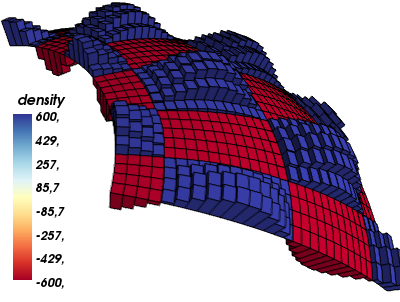

In [8]:
plot_result_3d(sample_mesh, 'example-mesh.png')

Calculate the gravity anomaly of this relief.

In [9]:
gz = tesseroid.gz(lon, lat, h, sample_mesh, njobs=ncpu)
gz = utils.contaminate(gz, 0.5)

<matplotlib.colorbar.Colorbar instance at 0x7fef23d99758>

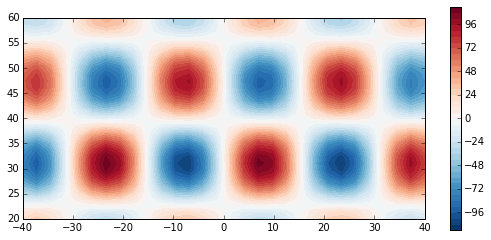

In [10]:
mpl.figure(figsize=(9, 4))
mpl.axis('scaled')
mpl.contourf(lon, lat, gz, shape, 40, cmap='RdBu_r')
mpl.colorbar()

## Make the Moho inversion class

Using the `fatiando.inversion` API. The inversion will use the method of Silva et al. 2014 to speedup computations. The Jacobian is approximated by a diagonal and the inversion solved with Gauss-Newton. Instead of using their approach to speed up convergence, we'll use the Levemberg-Marquardt method. Linear algebra operations should be cheap because all matrices involved are (very) sparse.

In [138]:
class Moho(Misfit):
    def __init__(self, lon, lat, height, data, mesh, njobs=1, field='gz'):
        super(Moho, self).__init__(data=data, nparams=mesh.size, islinear=False)
        assert mesh.size == data.size
        self.lon = lon
        self.lat = lat
        self.height = height
        self.mesh = mesh.copy(deep=True)
        self.jacobian = CachedMethodPermanent(self, 'jacobian')
        self.hessian = CachedMethodPermanent(self, 'hessian')
        self.field = field
        self._kernel = getattr(tesseroid, field)
        self.njobs = njobs
        self.pool = None
        self.scale = 1
        if field in 'gxx gxy gxz gyy gyz gzz'.split():
            self.scale = 0.001
        self.kernel_kwargs = dict()
        
    def config_kernel(self, **kwargs):
        self.kernel_kwargs = kwargs
        return self
    
    def set_scale(self, scale):
        self.scale = scale
        return self
        
    def fit(self):        
        if self.njobs > 1:
            self.pool = multiprocessing.Pool(self.njobs)
        super(Moho, self).fit()
        if self.pool is not None:
            self.pool.close()
            self.pool = None
        
    def predicted(self, p):
        mesh = self.mesh
        mesh.relief = p
        self.fix_density(mesh)
        njobs = self.njobs
        if self.pool is None:
            njobs = 1
        data = self._kernel(self.lon, self.lat, self.height, mesh, 
                            njobs=njobs, pool=self.pool, **self.kernel_kwargs)
        return data
    
    def fix_density(self, mesh):
        dens = mesh.props['density']
        should_b_pos = mesh.relief > mesh.reference
        dens[(should_b_pos) & (dens < 0)] *= -1
        dens[(~should_b_pos) & (dens > 0)] *= -1
        mesh.props['density'] = dens
        return mesh
    
    def jacobian(self, p):
        step = self.scale*utils.si2mgal(2*np.pi*constants.G*self.mesh.props['density'])
        jac = scipy.sparse.diags([np.abs(step)], [0]).tocsr()
        return jac
    
    def fmt_estimate(self, p):
        self.mesh.relief = p
        mesh = self.fix_density(self.mesh)
        return mesh

For a sythetic test, I'll try to invert the sample mesh above from noise corrupted data.

In [102]:
model = sample_mesh.copy(deep=True)
gz = tesseroid.gz(lon, lat, h, model, njobs=ncpu)
gz = utils.contaminate(gz, 1)

In [134]:
# Configure the inversion
mesh = sample_mesh.copy(deep=True)
mesh.props['density'] = 600*np.ones(mesh.size)

In [149]:
spacing = np.radians(gridder.spacing(area, shape))*constants.MEAN_EARTH_RADIUS
grid_area = spacing[1]*spacing[0]

In [154]:
solver = Moho(lon, lat, h, gz, mesh, njobs=ncpu)

In [164]:
initial = mesh.reference + utils.safe_solve(solver.jacobian(None), solver.data)

In [160]:
initial = np.ones(solver.nparams)*mesh.reference -30e3

In [165]:
solver.config('levmarq', initial=initial)

In [166]:
# Run the inversion and time the computation
t0 = time.time()
solver.fit()
dt = time.time() - t0
print("Time it took: {} s".format(dt))

Time it took: 15.8410840034 s


Plot the data misfit and residuals

In [167]:
predicted = solver.predicted()
residuals = solver.residuals()
moho = solver.estimate_

array([-120., -100.,  -80.,  -60.,  -40.,  -20.,    0.,   20.,   40.,
         60.,   80.,  100.,  120.])

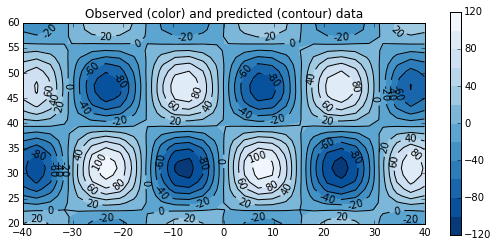

In [168]:
mpl.figure(figsize=(9, 4))
mpl.title('Observed (color) and predicted (contour) data')
mpl.axis('scaled')
levels = mpl.contourf(lon, lat, gz, shape, 12, cmap='Blues_r')
mpl.colorbar()
mpl.contour(lon, lat, predicted, shape, levels)

Mean: -0.000236005380886   std: 0.626482450267


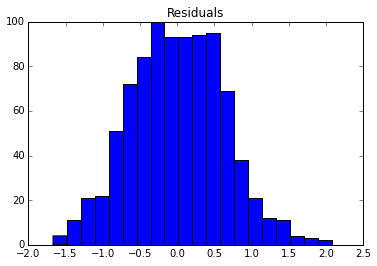

In [169]:
mpl.title('Residuals')
mpl.hist(residuals, bins=20)
print('Mean: {}   std: {}'.format(residuals.mean(), residuals.std()))

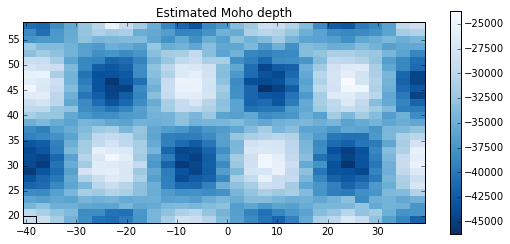

In [170]:
mpl.figure(figsize=(9, 4))
mpl.title("Estimated Moho depth")
mpl.axis('scaled')
mpl.pcolor(lon - dlon/2, lat - dlat/2, moho.relief, shape, cmap='Blues_r')
mpl.colorbar()
mpl.square(model[0].get_bounds()[:4])

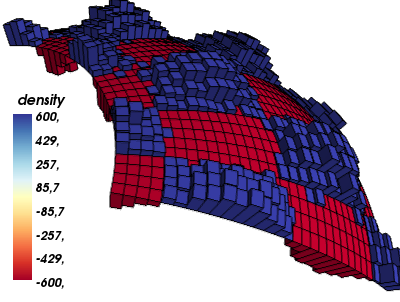

In [171]:
plot_result_3d(moho, 'simple-synthetic.png')

### Profile the inversion to see what is slow

I'll run the Python profiler (using the `%prun` IPython magic) to see where time is being spent in the inversion.

In [25]:
%prun -l 15 -q -T profiling.txt Moho(lon, lat, h, gz, mesh).config('levmarq', initial=initial).fit()
%cat profiling.txt

 
*** Profile printout saved to text file u'profiling.txt'. 
         680610 function calls (680546 primitive calls) in 31.143 seconds

   Ordered by: internal time
   List reduced from 195 to 15 due to restriction <15>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       31   29.956    0.966   31.070    1.002 tesseroid.py:288(_forward_model)
    27900    0.175    0.000    0.343    0.000 <ipython-input-3-67efef698e80>:53(__getitem__)
    27900    0.140    0.000    0.140    0.000 numpy_support.py:80(from_dtype)
    27900    0.135    0.000    0.476    0.000 context.py:130(resolve_data_type)
    27900    0.134    0.000    0.279    0.000 numpy_support.py:131(map_arrayscalar_type)
    27900    0.123    0.000    0.154    0.000 mesher.py:526(__init__)
    27900    0.080    0.000    0.577    0.000 dispatcher.py:178(typeof_pyval)
   225851    0.074    0.000    0.074    0.000 {isinstance}
    27900    0.068    0.000    0.092    0.000 tesseroid.py:230(_check_tesseroid)


So it seems that all of the time is spent on forward modeling. Making it parallel was not working because the overhead of forking the process (creating the pool of workers) is huge.

Should consider allowing the forward modeling to take the pool as an optional argument.

## Smoothness regularization

Test that the inversion works with smoothness regularization.

In [172]:
smooth = solver + 1e-3*Smoothness2D(mesh.shape)
smooth.config('levmarq', initial=initial)

In [173]:
t0 = time.time()
smooth.fit()
dt = time.time() - t0
print("Time it took: {} s".format(dt))

Time it took: 31.1745409966 s


In [174]:
predicted = smooth[0].predicted()
residuals = smooth[0].residuals()
moho = smooth.estimate_

array([-120., -100.,  -80.,  -60.,  -40.,  -20.,    0.,   20.,   40.,
         60.,   80.,  100.,  120.])

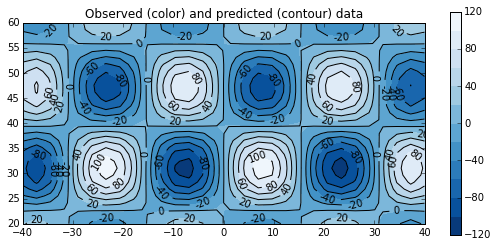

In [175]:
mpl.figure(figsize=(9, 4))
mpl.title('Observed (color) and predicted (contour) data')
mpl.axis('scaled')
levels = mpl.contourf(lon, lat, gz, shape, 12, cmap='Blues_r')
mpl.colorbar()
mpl.contour(lon, lat, predicted, shape, levels)

Mean: -0.000706816136311   std: 0.892424137979


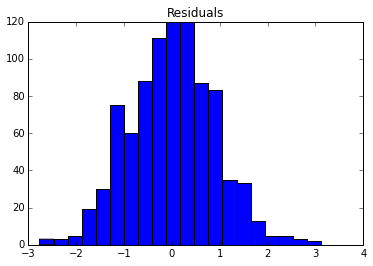

In [176]:
mpl.title('Residuals')
mpl.hist(residuals, bins=20)
print('Mean: {}   std: {}'.format(residuals.mean(), residuals.std()))

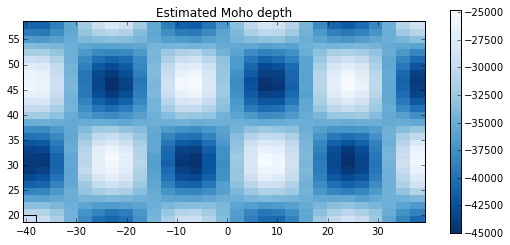

In [177]:
mpl.figure(figsize=(9, 4))
mpl.title("Estimated Moho depth")
mpl.axis('scaled')
mpl.pcolor(lon - dlon/2, lat - dlat/2, moho.relief, shape, cmap='Blues_r')
mpl.colorbar()
mpl.square(model[0].get_bounds()[:4])

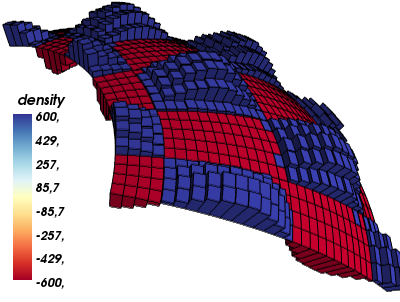

In [178]:
plot_result_3d(moho, 'smooth-synthetic.png')

## Inverting gravity gradients

Let's see if this methodology also works for gravity gradients.

First thing to do is generate the gradient data.

In [72]:
gzz = utils.contaminate(tesseroid.gzz(lon, lat, h, model, njobs=ncpu), 0.01)

In [73]:
def plot_data(data, cmap='RdBu_r'):
    mpl.figure(figsize=(9, 4))
    mpl.axis('scaled')
    scale = np.abs([data.min(), data.max()]).max()
    mpl.contourf(lon, lat, data, shape, 20, cmap=cmap, vmin=-scale, vmax=scale)
    mpl.colorbar()

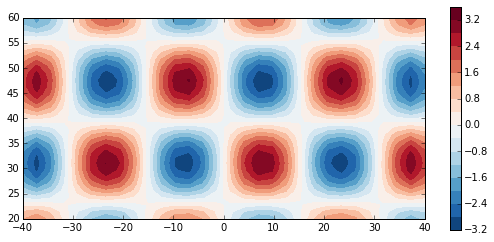

In [74]:
plot_data(gzz)

In [75]:
grad = (Moho(lon, lat, h, gzz, mesh, njobs=ncpu, field='gzz').set_scale(0.001).config_kernel(ratio=2.5)
        + 1e-8*Smoothness2D(mesh.shape))
grad.config('levmarq', initial=initial)

In [76]:
t0 = time.time()
grad.fit()
dt = time.time() - t0
print("Time it took: {} s".format(dt))

Time it took: 58.2774529457 s


In [77]:
predicted = grad[0].predicted()
residuals = grad[0].residuals()
moho = grad.estimate_

In [78]:
def plot_fit(data, predicted, cmap='RdBu_r'):
    mpl.figure(figsize=(9, 4))
    mpl.title('Observed (color) and predicted (contour) data')
    mpl.axis('scaled')
    scale = np.abs([data.min(), data.max()]).max()
    levels = mpl.contourf(lon, lat, data, shape, 12, cmap=cmap, vmin=-scale, vmax=scale)
    mpl.colorbar()
    mpl.contour(lon, lat, predicted, shape, levels)

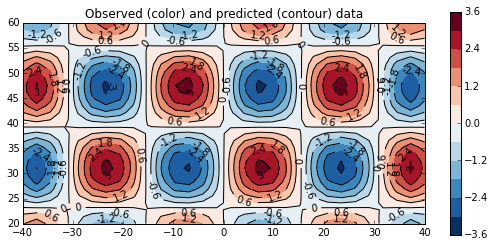

In [79]:
plot_fit(gzz, predicted)

Mean: -0.000410238929627   std: 0.00604775397801


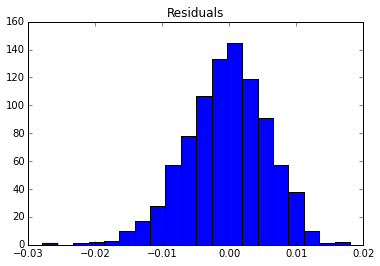

In [80]:
mpl.title('Residuals')
mpl.hist(residuals, bins=20)
print('Mean: {}   std: {}'.format(residuals.mean(), residuals.std()))

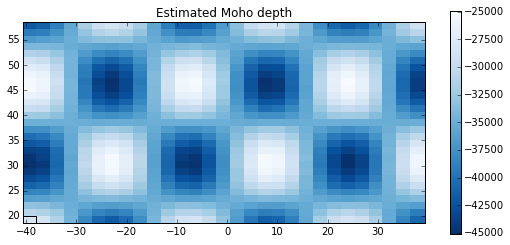

In [81]:
mpl.figure(figsize=(9, 4))
mpl.title("Estimated Moho depth")
mpl.axis('scaled')
mpl.pcolor(lon - dlon/2, lat - dlat/2, moho.relief, shape, cmap='Blues_r')
mpl.colorbar()
mpl.square(model[0].get_bounds()[:4])

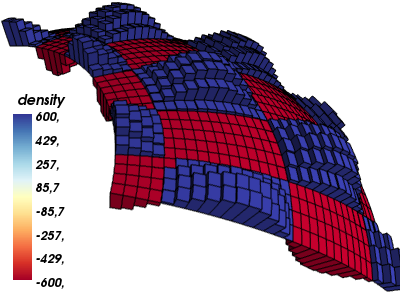

In [83]:
plot_result_3d(moho, 'grad-synthetic.png')

What worked for gradients is to reduce the value of the jacobian by just multiplying a constant. It works great for gzz but not the other components.

## Joint gz and gzz inversion

In [97]:
grad = Moho(lon, lat, h, gzz, mesh, njobs=ncpu, field='gzz')
grad.set_scale(0.001).config_kernel(ratio=2.5)
grav = Moho(lon, lat, h, gz, mesh, njobs=ncpu)
joint = ((1/np.linalg.norm(gz))*grav + (1/np.linalg.norm(gzz))*grad)[0]
#         + 1e-8*Smoothness2D(mesh.shape))
joint.config('levmarq', initial=initial)

In [98]:
t0 = time.time()
joint.fit()
dt = time.time() - t0
print("Time it took: {} s".format(dt))

Time it took: 14.1561150551 s


In [99]:
moho = joint.estimate_

In [100]:
mpl.figure(figsize=(9, 4))
for data, predicted in zip([gz, gzz], [joint[0].predicted(), joint[1].predicted()]):
    mpl.title('Observed (color) and predicted (contour) data')
    mpl.axis('scaled')
    scale = np.abs([data.min(), data.max()]).max()
    levels = mpl.contourf(lon, lat, data, shape, 12, cmap='RdYlBu_r', vmin=-scale, vmax=scale)
    mpl.colorbar()
    mpl.contour(lon, lat, predicted, shape, levels)

TypeError: 'Moho' object does not support indexing

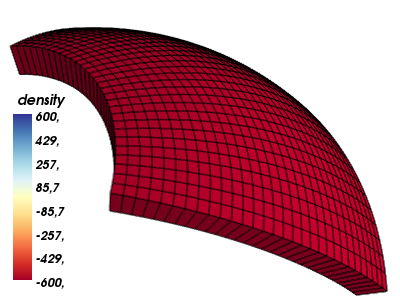

In [101]:
plot_result_3d(moho, 'joint-synthetic.png')

## Variable density

Lets see if the method for a Moho with a varying density contrast between crust and mantle.

In [132]:
model_varied = sample_mesh.copy(deep=True)
vardensity = -300*utils.gaussian2d(lon, lat, 50, 30, x0=-20, y0=50, angle=-45) + 600
isabove = model_varied.relief > model_varied.reference
vardensity[isabove] *= -1
model_varied.props['density'] = vardensity

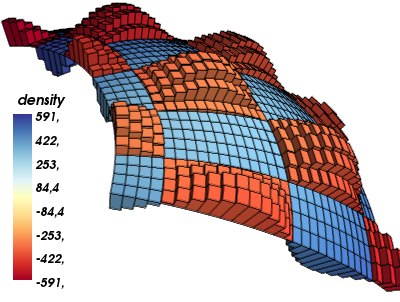

In [133]:
plot_result_3d(model_varied, 'variable-density-model.png')

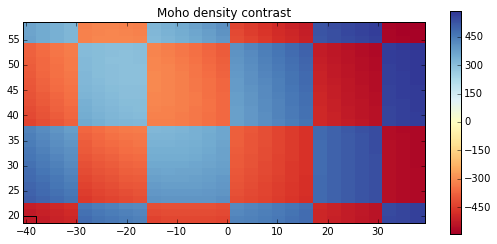

In [134]:
mpl.figure(figsize=(9, 4))
mpl.title("Moho density contrast")
mpl.axis('scaled')
mpl.pcolor(lon - dlon/2, lat - dlat/2, model_varied.props['density'], shape, cmap='RdYlBu')
mpl.colorbar()
mpl.square(model[0].get_bounds()[:4])

In [135]:
gz = utils.contaminate(tesseroid.gz(lon, lat, h, model_varied, njobs=ncpu), 1)

<matplotlib.colorbar.Colorbar instance at 0x7f7c18f25cf8>

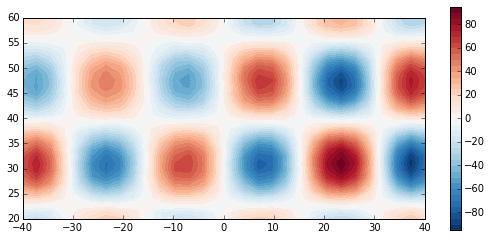

In [136]:
mpl.figure(figsize=(9, 4))
mpl.axis('scaled')
mpl.contourf(lon, lat, gz, shape, 40, cmap='RdBu_r')
mpl.colorbar()

In [149]:
mesh = model_varied.copy(deep=True)
vardens = Moho(lon, lat, h, gz, mesh, njobs=ncpu) + 1e-3*Smoothness2D(mesh.shape)
vardens.config('levmarq', initial=initial) 

In [150]:
t0 = time.time()
vardens.fit()
dt = time.time() - t0
print("Time it took: {} s".format(dt))

Time it took: 30.2019910812 s


In [151]:
predicted = vardens[0].predicted()
residuals = vardens[0].residuals()
moho = vardens.estimate_

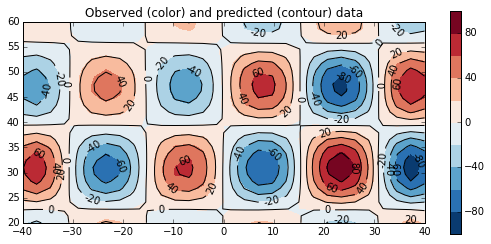

In [152]:
plot_fit(gz, predicted)

Mean: -0.000338464948351   std: 1.10549683605


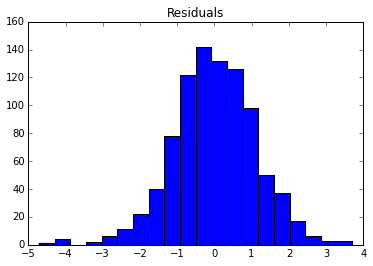

In [153]:
mpl.title('Residuals')
mpl.hist(residuals, bins=20)
print('Mean: {}   std: {}'.format(residuals.mean(), residuals.std()))

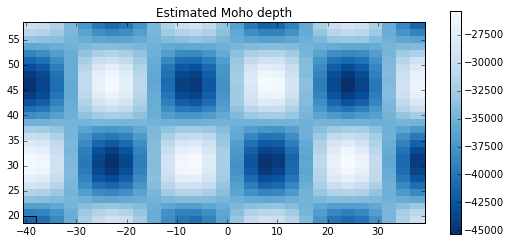

In [154]:
mpl.figure(figsize=(9, 4))
mpl.title("Estimated Moho depth")
mpl.axis('scaled')
mpl.pcolor(lon - dlon/2, lat - dlat/2, moho.relief, shape, cmap='Blues_r')
mpl.colorbar()
mpl.square(model[0].get_bounds()[:4])

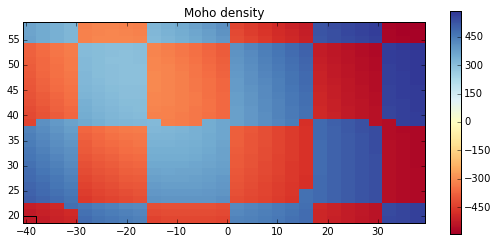

In [155]:
mpl.figure(figsize=(9, 4))
mpl.title("Moho density")
mpl.axis('scaled')
mpl.pcolor(lon - dlon/2, lat - dlat/2, moho.props['density'], shape, cmap='RdYlBu')
mpl.colorbar()
mpl.square(model[0].get_bounds()[:4])

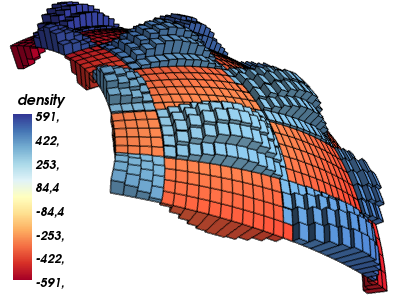

In [156]:
plot_result_3d(moho, 'variable-density-result.png')